In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import t
from plotnine import *


In [209]:
missing_values = ["n/a", "na", "--"]
combined_df_task2=pd.read_csv("files/combined_df_for_task2.csv",na_values = missing_values)

In [210]:
QVI_data=pd.read_csv("files/QVI_data.csv",na_values = missing_values)

In [211]:
QVI_data["DATE"]=pd.to_datetime(QVI_data["DATE"])

In [212]:
QVI_data['year_filter']=QVI_data['DATE'].dt.year
QVI_data['month_filter']=QVI_data['DATE'].dt.month
QVI_data['yyyymm']=QVI_data['year_filter'].astype(str)+QVI_data['month_filter'].astype(str).str.zfill(2)

## Part 1-Selecting Control Stores  <br>
Let's pick the control stores
Our trial stores are 77, 86, 88
Let's filter out the stores from before 2019 february.

In [213]:
QVI_data_pretrial=QVI_data.loc[(QVI_data['year_filter']<2019)|(QVI_data['year_filter']==2019)& (QVI_data['month_filter']<2)]

What we want to calculate: <br>
monthly overall sales for each store <br>
monthly number of customers for each store <br>
monthly number of transactions per store per customer <br>

Let's calculate these for our trial stores. Let's build a function to do that.

In [214]:
#function to get the averages
def find_monthly_numbers(storenumber,dataframe_name):
    filter=pd.DataFrame(dataframe_name.loc[(dataframe_name['STORE_NBR']==storenumber)])
    monthly_sale=pd.DataFrame(filter.groupby(['yyyymm'])['TOT_SALES'].sum())
    monthly_customer=pd.DataFrame(filter.groupby(['yyyymm'])['LYLTY_CARD_NBR'].nunique())
    monthly_transaction=pd.DataFrame(filter.groupby(['yyyymm','LYLTY_CARD_NBR'])['TOT_SALES'].sum())
    return monthly_sale,monthly_customer,monthly_transaction
#function to visualise the results
def create_graph(dataframe_to_visualise):
    fig,ax=plt.subplots()
    ax.plot(dataframe_to_visualise.index,dataframe_to_visualise.iloc[:,0])
    ax.set_xlabel(dataframe_to_visualise.index.name)
    ax.set_ylabel(dataframe_to_visualise.columns[0])

In [215]:
x,y,z=find_monthly_numbers(77,QVI_data_pretrial)
#create_graph(x)
#create_graph(y)
x2,y2,z2=find_monthly_numbers(86,QVI_data_pretrial)
#create_graph(x2)
#create_graph(y2)
x3,y3,z3=find_monthly_numbers(88,QVI_data_pretrial)
#create_graph(x3)
#create_graph(y3)


When we visualise the results we can see that monthly number of customers and monthly transactions follow a similar pattern.

Let's calculate
monthly overall sales for each store
monthly number of customers for each store
monthly number of transactions per store per customer
monthly chips per customer
average price per unit

In [216]:
#monthly overall sales for each store
overall_sales_pretrial=QVI_data_pretrial.groupby(['yyyymm','STORE_NBR'])['TOT_SALES'].sum()
overall_sales_pretrial=pd.DataFrame(overall_sales_pretrial)

In [217]:
overall_sales_pretrial=overall_sales_pretrial.unstack()
#overall_sales_pretrial

In [218]:
overall_sales_pretrial

TOT_SALES                                                        
STORE_NBR       1      2        3       4      5      6       7      8     
yyyymm                                                                     
201807        206.9  150.8  1205.70  1399.9  812.0  260.0  1024.7  381.6  \
201808        176.1  193.8  1079.75  1259.5  745.1  203.2  1119.9  383.0   
201809        278.8  154.4  1021.50  1198.6  896.0  207.7  1147.3  293.0   
201810        188.1  167.8  1037.90  1346.4  798.0  292.4  1063.9  422.8   
201811        192.6  162.9  1008.00  1212.0  771.4  255.3  1076.5  349.2   
201812        189.6  136.0  1121.60  1185.6  879.2  209.1   906.1  356.4   
201901        154.8  162.8  1051.70  1525.0  838.0  191.1   975.1  445.0   

                          ...                                            
STORE_NBR    9       10   ...   263    264    265    266   267     268   
yyyymm                    ...                                            
201807     289.7  892.00  ...  38.7  232.6  247.8  127.3   6.2  224.00  \
201808     327.5  878.65  ...  28.0  203.3  227.1  154.5  24.9  322.65   
201809     369.7  945.00  ...  21.8  199.5  133.5  139.0  23.3  174.40   
201810     361.0  910.80  ...  36.6  170.0  162.9  170.4  14.4  237.60   
201811     374.4  885.00  ...  15.8  184.5  282.8  144.2  40.3  225.40   
201812     382.6  936.60  ...  24.6  288.5  205.3  157.8  15.4  207.30   
201901     399.4  878.60  ...  21.3  247.3  176.7  148.7  34.4  157.70   

                                           
STORE_NBR     269      270    271     272  
yyyymm                                     
201807      982.0   962.80  956.6  433.10  
201808      835.1  1003.75  683.9  372.85  
201809      886.0   845.40  798.4  304.70  
201810     1078.4   816.40  790.0  430.60  
201811      967.2   965.00  886.4  376.20  
201812      935.4  1038.00  807.4  403.90  
201901      980.4  1066.60  842.4  423.00  

[7 rows x 271 columns]

**We are looking for control stores for 77,86 and 88. Let's create a function that finds the correlation between the given store and all other stores, and picks the stores above a certain correlation.**

In [219]:
def sales_correlation(trial_store,threshold):
    x = overall_sales_pretrial.corrwith(overall_sales_pretrial.iloc[:, (trial_store-1)])
    x=x.unstack().transpose()
    x=pd.DataFrame(x)
    x = x.loc[:, (x != 0).any(axis=0)]
    x = x.rename(columns={x.columns[0]: 'columnname'})
    x.index.name = 'index'
    x=x[x['columnname']>threshold]
    return x
    #sns.scatterplot(data=x)


Now we can easily see the correlated stores

In [220]:
sales_correlation(77,0.8)

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


,columnname
index,
3,0.806644
11,1.000000
17,0.842668
31,1.000000
71,0.914106
77,1.000000
119,0.867664
233,0.903774


In [221]:
sales_correlation(86,0.8)

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


,columnname
index,
31,1.000000
86,1.000000
132,0.846517
155,0.877882
240,0.825066


In [222]:
sales_correlation(88,0.8)

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


,columnname
index,
1,0.813636
88,1.000000
134,0.864293
159,0.903186
204,0.885774
253,0.811838


In [223]:
#monthly number of customer for each store
customer_number_pretrial=QVI_data_pretrial.groupby(['yyyymm','STORE_NBR'])['LYLTY_CARD_NBR'].nunique()
customer_number_pretrial=pd.DataFrame(customer_number_pretrial)

In [224]:
#customer_number_pretrial=customer_number_pretrial.unstack()
def customer_number_correlation(trial_store, threshold):
    y1=customer_number_pretrial.unstack()
    y = y1.corrwith(y1.iloc[:, (trial_store-1)])
    y=y.unstack().transpose()
    y = y.loc[:, (y != 0).any(axis=0)]
    y=pd.DataFrame(y)
    y.index.name = 'index'
    y = y.rename(columns={y.columns[0]: 'columnname'})
    y=y[y['columnname']>threshold]
    return y


In [225]:
customer_number_correlation(77, 0.8)

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


,columnname
index,
3,0.834207
41,0.844219
77,1.000000
84,0.858571
113,0.901348
119,0.983267
233,0.990358
254,0.916208


In [226]:
customer_number_correlation(86, 0.8)

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


,columnname
index,
86,1.000000
114,0.855339
155,0.942876
260,0.846502


In [227]:
customer_number_correlation(88, 0.8)

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


,columnname
index,
14,0.942976
35,0.899594
69,0.815792
88,1.000000
113,0.862632
178,0.939466
237,0.947326
265,0.841013


In [228]:
#monthly number of transactions per store per customer
customer_transaction_pretrial=QVI_data_pretrial.groupby(['yyyymm','STORE_NBR','LYLTY_CARD_NBR'])['TOT_SALES'].sum()
customer_transaction_pretrial=pd.DataFrame(customer_transaction_pretrial)

In [229]:
#monthly chips per customer
chips_per_customer=QVI_data_pretrial.groupby(['yyyymm','STORE_NBR','LYLTY_CARD_NBR'])['PROD_QTY'].sum()
chips_per_customer=pd.DataFrame(chips_per_customer)

If we use our previous functions we can pick our control stores. Let's find the stores that are correlated to our trial stores in both customer number and sales.

In [230]:
#store 77
store77_1=sales_correlation(77,0.9)
store77_2=customer_number_correlation(77, 0.9)
common_index = set(store77_1.index).intersection(set(store77_2.index))
common_index_list = list(common_index)
common_index_list

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


[233, 77]

In [231]:
#store 86
store86_1=sales_correlation(86,0.8)
store86_2=customer_number_correlation(86, 0.8)
common_index = set(store86_1.index).intersection(set(store86_2.index))
common_index_list = list(common_index)
common_index_list

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


[155, 86]

In [232]:
#store 88
store88_1=sales_correlation(88,0.7)
store88_2=customer_number_correlation(88, 0.7)
common_index = set(store88_1.index).intersection(set(store88_2.index))
common_index_list = list(common_index)
common_index_list

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide


[88, 178]

To find correlated stores in both customer number and transactions, I played with the correlation value. Store 77 had a high correlation to 233 however the other two trial stores didn't have another store that was that much correlated with them. In order to get similar stores that have a similar pattern, I lowered the correlation value.

We can see that;
store 233 has a high correlation to store 77 in both cutomer numbers and sales.<br>
Store 155 has a high correlation to store 86 in both cutomer numbers and sales <br>
Store 178 has a high correlation to store 88 in both cutomer numbers and sales <br>

We can now use the function we created to visualise the trial store transactions and customer numbers to check if our control stores show similar patterns as we expected.

In [233]:
x,y,z=find_monthly_numbers(77,QVI_data_pretrial)


In [234]:
def create_graph(trial_store,control_store):
    #remember x,y,z=monthly_sale,monthly_customer,monthly_transaction
    x,y,z=find_monthly_numbers(trial_store,QVI_data_pretrial)
    x1,y1,z1=find_monthly_numbers(control_store,QVI_data_pretrial)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
    #monthly sale control vs trial store
    ax = x.plot(kind='line', marker='o', label='Trial Store', ax=axs[0])
    x1.plot(kind='line', marker='s', label='Control Store',ax=axs[0])
    axs[0].set_title('Monthly Sales Trial vs Control Store')
    axs[0].set_xlabel('Month')
    axs[0].set_ylabel('Sales')
    axs[0].legend(labels=['Trial Store', 'Control Store'])

    #monthly customer control vs trial store.
    ax = y.plot(kind='line', marker='o', label='Trial Store' ,ax=axs[1])
    y1.plot(kind='line', marker='s',label='Control Store', ax=axs[1])
    axs[1].set_title('Monthly Customer Trial vs Control Store')
    axs[1].set_xlabel('Month')
    axs[1].set_ylabel('Customer Count')
    axs[1].legend(labels=['Trial Store', 'Control Store'])
    
    plt.subplots_adjust(wspace=1.0)

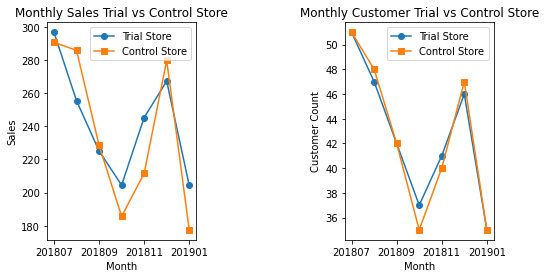

In [235]:
create_graph(77,233)

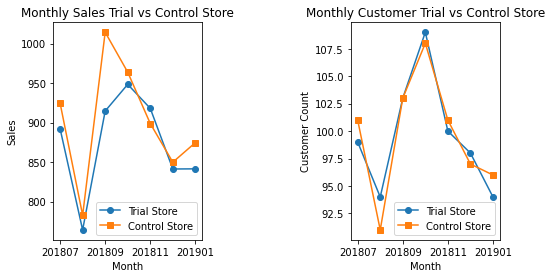

In [236]:
create_graph(86,155)

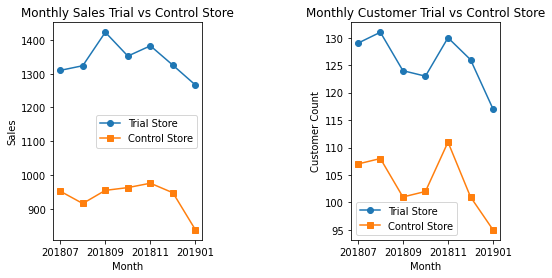

In [237]:
create_graph(88,178)

We can see that all these stores indeed have similar trends! We can now go on to see assess if the trial stores have shown any improvement.

# Part 2- Assessment of trial #

## Stores 77 and 233 assessment ##

### Assessing monthly sales ###

We will first find the scaling factor, we find this by dividing pretrial trial store numbers by pretrial trial store numbers

In [239]:
QVI_data_pretrial=QVI_data.loc[(QVI_data['year_filter']<2019)|(QVI_data['year_filter']==2019)& (QVI_data['month_filter']<3)]

### Finding the scaling factors between control and trial stores ###

In [240]:
#scale factor for monthly_sale_233 
pretrial_sale_77,pretrial_customer_77,pretrial_transaction_77=find_monthly_numbers(77,QVI_data_pretrial)
pretrial_sale_233,pretrial_customer_233,pretrial_transaction_233=find_monthly_numbers(233,QVI_data_pretrial)
scaling_77_233=pretrial_sale_77.sum()/pretrial_sale_233.sum()

In [241]:
QVI_data_assess=QVI_data.loc[(QVI_data['year_filter']>2019)|(QVI_data['year_filter']==2019)& (QVI_data['month_filter']>2)]

### Finding the transaction patterns during the trial period ###

In [242]:
trial_monthly_sale_77,trial_monthly_customer_77,trial_monthly_transaction_77=find_monthly_numbers(77,QVI_data_assess)
trial_monthly_sale_233,trial_monthly_customer_233,trial_monthly_transaction_233=find_monthly_numbers(233,QVI_data_assess)


### Scaling up the control stores & finding the percentage difference. ###

We now have seperate tables for pre-trial and trial periods. Let's merge the tables

In [243]:
saletable77 = pd.concat([pretrial_sale_77, trial_monthly_sale_77])
scaledsaletable233 = pd.concat([pretrial_sale_233, trial_monthly_sale_233])*scaling_77_233
mergedsale77_233 = pd.merge(saletable77, scaledsaletable233, left_index=True, right_index=True)
mergedsale77_233.rename(columns={'TOT_SALES_x': 'saletable77', 'TOT_SALES_y': 'scaledsaletable233'}, inplace=True)
mergedsale77_233['percentagediff']=(abs(mergedsale77_233['scaledsaletable233']-mergedsale77_233['saletable77']))/mergedsale77_233['scaledsaletable233']

### Finding the stdev and the t_value ###

In [244]:
mergedsale77_233['YEARMONTH']=mergedsale77_233.index
mergedsale77_233['YEARMONTH']=mergedsale77_233['YEARMONTH'].astype(int)
stdDev = np.std(mergedsale77_233[mergedsale77_233['YEARMONTH'] < 201902]['percentagediff'].values)
degreesOfFreedom = 7

In [245]:
#finding the t_value
mergedsale77_233['tValue'] = (mergedsale77_233['percentagediff'] - 0) / stdDev
mergedsale77_233['TransactionMonth'] = pd.to_datetime(mergedsale77_233['YEARMONTH'].astype(str), format='%Y%m')
#finding the t_value of 2019-02, 2019-03, 2019-04
result77_233 = mergedsale77_233[(mergedsale77_233['YEARMONTH'] < 201905) & (mergedsale77_233['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
#the t value of the 95th percentile
t_value = t.ppf(0.95, df=degreesOfFreedom)

print(result77_233)
print('the t value of the 95th percentile:', t_value)

       TransactionMonth     tValue
yyyymm                            
201902       2019-02-01   1.062077
201903       2019-03-01   7.710263
201904       2019-04-01  12.998029
the t value of the 95th percentile: 1.894578605061305


We can see that the t values of march and april are higher than the 95th percentile meaning the increase in sales in the trial store during the trial period was statistically higher than the control store.

### Let's create a nice plot to show our results ###

In [246]:
#will use for visualisation
forvisualisation = QVI_data.groupby(['STORE_NBR', 'yyyymm']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
).reset_index().sort_values(['STORE_NBR', 'yyyymm'])

In [247]:
forvisualisation

,STORE_NBR,yyyymm,totSales,nCustomers
0,1,201807,206.9,49
1,1,201808,176.1,42
2,1,201809,278.8,59
3,1,201810,188.1,44
4,1,201811,192.6,46
...,...,...,...,...
3164,272,201902,395.5,45
3165,272,201903,442.3,50
3166,272,201904,445.1,54
3167,272,201905,314.6,34


In [249]:
#defining a function to use for visualisation later on

def sales_for_visualisation(trial_store,control_store):
    a='QVI_data_'+str(trial_store)+'_'+str(control_store)
    a=forvisualisation.copy()
    a['Store_type'] = np.where(a['STORE_NBR'] == trial_store, "Trial",np.where(a['STORE_NBR'] == control_store, "Control", "Other stores"))
    a = a.groupby(['yyyymm', 'Store_type']).mean('TOT_SALES').reset_index()
    #a = a.groupby(['yyyymm', 'Store_type']).agg({'totSales': 'mean'}).reset_index()

    a['TransactionMonth'] = pd.to_datetime(a['yyyymm'].astype(str), format='%Y%m')
    a = a[a['Store_type'].isin(['Trial', 'Control'])]
 
    pastSales_Controls95 = a[a['Store_type'] == 'Control'].copy()
    pastSales_Controls95['stdDev'] = pastSales_Controls95['totSales'].std()
    pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + pastSales_Controls95['stdDev'] * 2)
    pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

    pastSales_Controls = a[a['Store_type'] == 'Control']
    stdDev = pastSales_Controls['totSales'].std()
    pastSales_Controls5 = pastSales_Controls.copy()
    pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
    pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'
    
    trial_assessment = pd.concat([a, pastSales_Controls95, pastSales_Controls5], ignore_index=True)
    
    #return trial_assessment
    return a

trial_dataframe=sales_for_visualisation(77,233)

In [250]:
rect_data = trial_dataframe[(trial_dataframe['yyyymm'].astype(int) < 201905) &
                            (trial_dataframe['yyyymm'].astype(int) > 201901)]

In [251]:
transaction_month = pd.to_datetime(rect_data['TransactionMonth'])
xmin = transaction_month.min()
xmax = transaction_month.max()
ymin=0
ymax=float('inf')

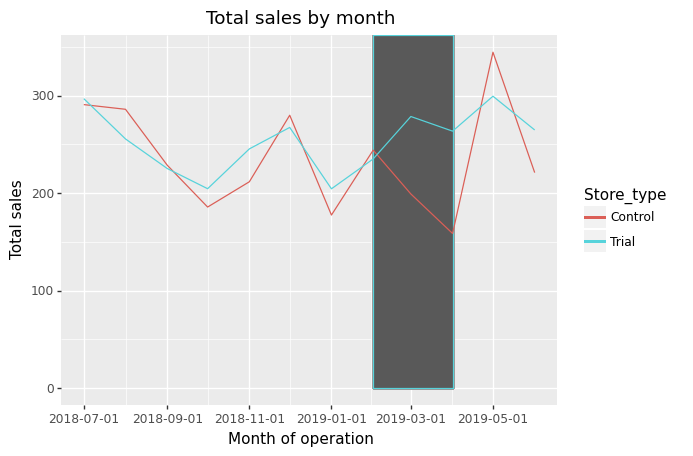

<ggplot: (8781267189836)>

In [252]:
ggplot(trial_dataframe, aes('TransactionMonth', 'totSales', color='Store_type')) \
    + geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin,
                  ymax=ymax,alpha=0.2 ), show_legend=False)\
    + geom_line() + labs(x="Month of operation", y="Total sales", title="Total sales by month")


### Assessing number of customers ###

### Finding the scaling factor ###

In [253]:
scaling_77_233_customer=pretrial_customer_77.sum()/pretrial_customer_233.sum()

### Scaling up the control stores & finding the percentage difference. ###

We now have seperate tables for pre-trial and trial periods. Let's merge the tables

In [254]:
trial_monthly_sale_77,trial_monthly_customer_77,trial_monthly_transaction_77=find_monthly_numbers(77,QVI_data_assess)
trial_monthly_sale_233,trial_monthly_customer_233,trial_monthly_transaction_233=find_monthly_numbers(233,QVI_data_assess)


In [255]:
custtable77 = pd.concat([pretrial_customer_77, trial_monthly_customer_77])
scaledcusttable233 = pd.concat([pretrial_customer_233, trial_monthly_customer_233])*scaling_77_233_customer
mergedcust77_233 = pd.merge(custtable77, scaledcusttable233, left_index=True, right_index=True)
mergedcust77_233.rename(columns={'LYLTY_CARD_NBR_x': 'customerTable77', 'LYLTY_CARD_NBR_y': 'scaledCustomerTable233'}, inplace=True)
mergedcust77_233['percentagediff']=(abs(mergedcust77_233['scaledCustomerTable233']-mergedcust77_233['customerTable77']))/mergedcust77_233['scaledCustomerTable233']

In [256]:
mergedcust77_233

,customerTable77,scaledCustomerTable233,percentagediff
yyyymm,,,
201807,51,51.148688,0.002907
201808,47,48.139942,0.023680
201809,42,42.122449,0.002907
201810,37,35.102041,0.054070
201811,41,40.116618,0.022020
201812,46,47.137026,0.024122
201901,35,35.102041,0.002907
201902,45,45.131195,0.002907
201903,50,40.116618,0.246366


## Finding the stdev and the t_value ###

In [262]:
#finding the standard deviation
mergedcust77_233['YEARMONTH']=mergedcust77_233.index
mergedcust77_233['YEARMONTH']=mergedcust77_233['YEARMONTH'].astype(int)
stdDev = np.std(mergedcust77_233[mergedcust77_233['YEARMONTH'] < 201902]['percentagediff'].values)
degreesOfFreedom = 7

In [263]:
#finding the t_value
mergedcust77_233['tValue'] = (mergedcust77_233['percentagediff'] - 0) / stdDev
mergedcust77_233['TransactionMonth'] = pd.to_datetime(mergedcust77_233['YEARMONTH'].astype(str), format='%Y%m')
#finding the t_value of 2019-02, 2019-03, 2019-04
resultcust77_233 = mergedcust77_233[(mergedcust77_233['YEARMONTH'] < 201905) & (mergedcust77_233['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
#the t value of the 95th percentile
t_value = t.ppf(0.95, df=degreesOfFreedom)

print(resultcust77_233)
print('the t value of the 95th percentile:', t_value)

       TransactionMonth     tValue
yyyymm                            
201902       2019-02-01   0.169289
201903       2019-03-01  14.347203
201904       2019-04-01  32.734759
the t value of the 95th percentile: 1.894578605061305


### Let's create a nice plot to show our results ###

In [264]:
#Let's use the function we've created for sales

customer77_233_dataframe=sales_for_visualisation(77,233)
customer77_233_dataframe

,yyyymm,Store_type,STORE_NBR,totSales,nCustomers,TransactionMonth
0,201807,Control,233.0,290.7,51.0,2018-07-01
2,201807,Trial,77.0,296.8,51.0,2018-07-01
3,201808,Control,233.0,285.9,48.0,2018-08-01
5,201808,Trial,77.0,255.5,47.0,2018-08-01
6,201809,Control,233.0,228.6,42.0,2018-09-01
8,201809,Trial,77.0,225.2,42.0,2018-09-01
9,201810,Control,233.0,185.7,35.0,2018-10-01
11,201810,Trial,77.0,204.5,37.0,2018-10-01
12,201811,Control,233.0,211.6,40.0,2018-11-01
14,201811,Trial,77.0,245.3,41.0,2018-11-01


In [265]:
rect_data = customer77_233_dataframe[(customer77_233_dataframe['yyyymm'].astype(int) < 201905) &
                            (customer77_233_dataframe['yyyymm'].astype(int) > 201901)]

In [266]:
transaction_month = pd.to_datetime(rect_data['TransactionMonth'])
xmin = transaction_month.min()
xmax = transaction_month.max()
ymin=0
ymax=float('inf')

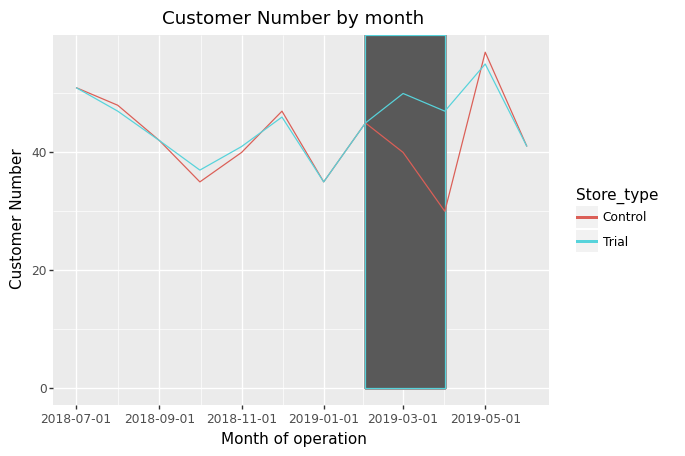

<ggplot: (8781211655476)>

In [268]:
ggplot(customer77_233_dataframe, aes('TransactionMonth', 'nCustomers', color='Store_type')) \
    + geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin,
                  ymax=ymax,alpha=0.2 ), show_legend=False)\
    + geom_line() + labs(x="Month of operation", y="Customer Number", title="Customer Number by month")


## Stores 86 and 155 assessment ##

### Assessing monthly sales ###


In [269]:
QVI_data_pretrial=QVI_data.loc[(QVI_data['year_filter']<2019)|(QVI_data['year_filter']==2019)& (QVI_data['month_filter']<3)]

### Finding the scaling factors between control and trial stores ###

In [277]:
#scale factor for monthly_sale_155 
pretrial_sale_86,pretrial_customer_86,pretrial_transaction_86=find_monthly_numbers(86,QVI_data_pretrial)
pretrial_sale_155,pretrial_customer_155,pretrial_transaction_155=find_monthly_numbers(155,QVI_data_pretrial)

scaling_86_155=pretrial_sale_86.sum()/pretrial_sale_155.sum()

In [278]:
QVI_data_assess=QVI_data.loc[(QVI_data['year_filter']>2019)|(QVI_data['year_filter']==2019)& (QVI_data['month_filter']>2)]

### Finding the transaction patterns during the trial period ###

In [279]:
trial_monthly_sale_86,trial_monthly_customer_86,trial_monthly_transaction_86=find_monthly_numbers(86,QVI_data_assess)
trial_monthly_sale_155,trial_monthly_customer_155,trial_monthly_transaction_155=find_monthly_numbers(155,QVI_data_assess)


### Scaling up the control stores & finding the percentage difference. ###

In [280]:
saletable86 = pd.concat([pretrial_sale_86, trial_monthly_sale_86])
scaledsaletable155 = pd.concat([pretrial_sale_155, trial_monthly_sale_155])*scaling_86_155
mergedsale86_155 = pd.merge(saletable86, scaledsaletable155, left_index=True, right_index=True)
mergedsale86_155.rename(columns={'TOT_SALES_x': 'saletable86', 'TOT_SALES_y': 'scaledsaletable155'}, inplace=True)
mergedsale86_155['percentagediff']=(abs(mergedsale86_155['scaledsaletable155']-mergedsale86_155['saletable86']))/mergedsale86_155['scaledsaletable155']

### Finding the stdev and the t_value ###

In [281]:
mergedsale86_155['YEARMONTH']=mergedsale86_155.index
mergedsale86_155['YEARMONTH']=mergedsale86_155['YEARMONTH'].astype(int)
stdDev = np.std(mergedsale86_155[mergedsale86_155['YEARMONTH'] < 201902]['percentagediff'].values)
degreesOfFreedom = 7

In [282]:
#finding the t_value
mergedsale86_155['tValue'] = (mergedsale86_155['percentagediff'] - 0) / stdDev
mergedsale86_155['TransactionMonth'] = pd.to_datetime(mergedsale86_155['YEARMONTH'].astype(str), format='%Y%m')
#finding the t_value of 2019-02, 2019-03, 2019-04
result86_155 = mergedsale86_155[(mergedsale86_155['YEARMONTH'] < 201905) & (mergedsale86_155['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
#the t value of the 95th percentile
t_value = t.ppf(0.95, df=degreesOfFreedom)

print(result86_155)
print('the t value of the 95th percentile:', t_value)

       TransactionMonth     tValue
yyyymm                            
201902       2019-02-01   1.948453
201903       2019-03-01  12.199404
201904       2019-04-01   1.116980
the t value of the 95th percentile: 1.894578605061305


We can see that both 201902 and 201904 have lower values than 1.96. So for those two months the difference between the control and the trial stores are not significant.

### Let's create a nice plot to show our results ###

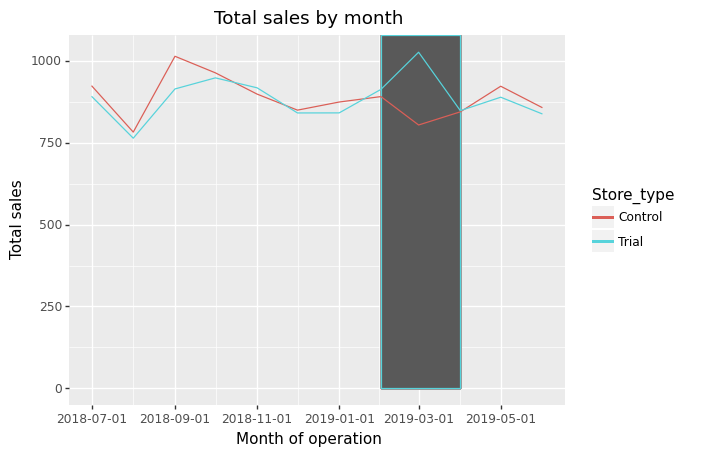

<ggplot: (8781280250305)>

In [283]:
trial_dataframe86_155=sales_for_visualisation(86,155)


rect_data = trial_dataframe86_155[(trial_dataframe86_155['yyyymm'].astype(int) < 201905) &
                            (trial_dataframe86_155['yyyymm'].astype(int) > 201901)]

transaction_month = pd.to_datetime(rect_data['TransactionMonth'])
xmin = transaction_month.min()
xmax = transaction_month.max()
ymin=0
ymax=float('inf')


ggplot(trial_dataframe86_155, aes('TransactionMonth', 'totSales', color='Store_type')) \
    + geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin,
                  ymax=ymax,alpha=0.2 ), show_legend=False)\
    + geom_line() + labs(x="Month of operation", y="Total sales", title="Total sales by month")


The plot shows the difference between the control and trial store sales wihtin the trial period. This is a nice way to confirm our findings above.

### Assessing number of customers ###


### Finding the scaling factor ###

In [284]:
scaling_86_155_customer=pretrial_customer_86.sum()/pretrial_customer_155.sum()

### Scaling up the control stores & finding the percentage difference. ###

In [285]:
custtable86 = pd.concat([pretrial_customer_86, trial_monthly_customer_86])
scaledcusttable155 = pd.concat([pretrial_customer_155, trial_monthly_customer_155])*scaling_86_155_customer
mergedcust86_155 = pd.merge(custtable86, scaledcusttable155, left_index=True, right_index=True)
mergedcust86_155.rename(columns={'LYLTY_CARD_NBR_x': 'customerTable86', 'LYLTY_CARD_NBR_y': 'scaledCustomerTable155'}, inplace=True)
mergedcust86_155['percentagediff']=(abs(mergedcust86_155['scaledCustomerTable155']-mergedcust86_155['customerTable86']))/mergedcust86_155['scaledCustomerTable155']

## Finding the stdev and the t_value ###

In [286]:
#finding the standard deviation
mergedcust86_155['YEARMONTH']=mergedcust86_155.index
mergedcust86_155['YEARMONTH']=mergedcust86_155['YEARMONTH'].astype(int)
stdDev = np.std(mergedcust86_155[mergedcust86_155['YEARMONTH'] < 201902]['percentagediff'].values)
degreesOfFreedom = 7

In [288]:
#finding the t_value
mergedcust86_155['tValue'] = (mergedcust86_155['percentagediff'] - 0) / stdDev
mergedcust86_155['TransactionMonth'] = pd.to_datetime(mergedcust86_155['YEARMONTH'].astype(str), format='%Y%m')
#finding the t_value of 2019-02, 2019-03, 2019-04
resultcust86_155 = mergedcust86_155[(mergedcust86_155['YEARMONTH'] < 201905) & (mergedcust86_155['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
#the t value of the 95th percentile
t_value = t.ppf(0.95, df=degreesOfFreedom)

print(resultcust86_155)
print('the t value of the 95th percentile:', t_value)

       TransactionMonth     tValue
yyyymm                            
201902       2019-02-01   9.484050
201903       2019-03-01  17.767214
201904       2019-04-01   3.877983
the t value of the 95th percentile: 1.894578605061305


### Let's create a nice plot to show our results ###


In [289]:
#forvisualisation

In [291]:
#Let's use the function we've created for sales
customer86_155_dataframe=sales_for_visualisation(86,155)
customer86_155_dataframe

,yyyymm,Store_type,STORE_NBR,totSales,nCustomers,TransactionMonth
0,201807,Control,155.0,924.60,101.0,2018-07-01
2,201807,Trial,86.0,892.20,99.0,2018-07-01
3,201808,Control,155.0,782.70,91.0,2018-08-01
5,201808,Trial,86.0,764.05,94.0,2018-08-01
6,201809,Control,155.0,1014.40,103.0,2018-09-01
8,201809,Trial,86.0,914.60,103.0,2018-09-01
9,201810,Control,155.0,963.80,108.0,2018-10-01
11,201810,Trial,86.0,948.40,109.0,2018-10-01
12,201811,Control,155.0,898.80,101.0,2018-11-01
14,201811,Trial,86.0,918.00,100.0,2018-11-01


In [293]:
rect_data = customer86_155_dataframe[(customer86_155_dataframe['yyyymm'].astype(int) < 201905) &
                            (customer86_155_dataframe['yyyymm'].astype(int) > 201901)]

In [294]:
transaction_month = pd.to_datetime(rect_data['TransactionMonth'])
xmin = transaction_month.min()
xmax = transaction_month.max()
ymin=0
ymax=float('inf')

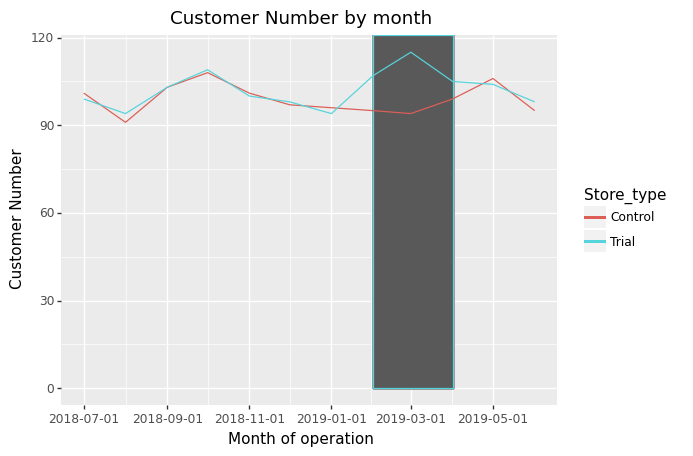

<ggplot: (8781178371226)>

In [295]:
ggplot(customer86_155_dataframe, aes('TransactionMonth', 'nCustomers', color='Store_type')) \
    + geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin,
                  ymax=ymax,alpha=0.2 ), show_legend=False)\
    + geom_line() + labs(x="Month of operation", y="Customer Number", title="Customer Number by month")


It looks like the customer numbers are significantly higher.

## Stores 88 and 178 assessment ##

### Assessing monthly sales ###


In [297]:
QVI_data_pretrial=QVI_data.loc[(QVI_data['year_filter']<2019)|(QVI_data['year_filter']==2019)& (QVI_data['month_filter']<3)]

### Finding the scaling factors between control and trial stores ###

In [300]:
#scale factor for  monthly_sale_178 
pretrial_sale_88,pretrial_customer_88,pretrial_transaction_88=find_monthly_numbers(88,QVI_data_pretrial)
pretrial_sale_178,pretrial_customer_178,pretrial_transaction_178=find_monthly_numbers(178,QVI_data_pretrial)
scaling_88_178=pretrial_sale_88.sum()/pretrial_sale_178.sum()

In [195]:
QVI_data_assess=QVI_data.loc[(QVI_data['year_filter']>2019)|(QVI_data['year_filter']==2019)& (QVI_data['month_filter']>2)]


In [192]:
#pretrial_sale_88,pretrial_sale_178
#scaling_88_178

TOT_SALES    1.408801
dtype: float64

### Finding the transaction patterns during the trial period ###

In [186]:
trial_monthly_sale_88,trial_monthly_customer_88,trial_monthly_transaction_88=find_monthly_numbers(88,QVI_data_assess)
trial_monthly_sale_178,trial_monthly_customer_178,trial_monthly_transaction_178=find_monthly_numbers(178,QVI_data_assess)


### Scaling up the control stores & finding the percentage difference. ###

In [306]:
saletable88 = pd.concat([pretrial_sale_88, trial_monthly_sale_88])
scaledsaletable178 = pd.concat([pretrial_sale_178, trial_monthly_sale_178])*scaling_88_178
mergedsale88_178 = pd.merge(saletable88, scaledsaletable178, left_index=True, right_index=True)
mergedsale88_178.rename(columns={'TOT_SALES_x': 'saletable88', 'TOT_SALES_y': 'scaledsaletable178'}, inplace=True)
mergedsale88_178['percentagediff']=(abs(mergedsale88_178['scaledsaletable178']-mergedsale88_178['saletable88']))/mergedsale88_178['scaledsaletable178']

In [307]:
mergedsale88_178

,saletable88,scaledsaletable178,percentagediff
yyyymm,,,
201807,1310.00,1341.178468,0.023247
201808,1323.80,1289.757235,0.026395
201809,1423.00,1344.559590,0.058339
201810,1352.40,1356.111758,0.002737
201811,1382.80,1374.426170,0.006093
201812,1325.20,1334.416224,0.006907
201901,1266.40,1179.448123,0.073723
201902,1370.20,1533.902433,0.106723
201903,1477.20,1407.110351,0.049811


### Finding the stdev and the t_value ###

In [311]:
mergedsale88_178['YEARMONTH']=mergedsale88_178.index
mergedsale88_178['YEARMONTH']=mergedsale88_178['YEARMONTH'].astype(int)
stdDev = np.std(mergedsale88_178[mergedsale88_178['YEARMONTH'] < 201902]['percentagediff'].values)
degreesOfFreedom = 7
mergedsale88_178

,saletable88,scaledsaletable178,percentagediff,YEARMONTH,tValue,TransactionMonth
yyyymm,,,,,,
201807,1310.00,1341.178468,0.023247,201807,0.906958,2018-07-01
201808,1323.80,1289.757235,0.026395,201808,1.029760,2018-08-01
201809,1423.00,1344.559590,0.058339,201809,2.276034,2018-09-01
201810,1352.40,1356.111758,0.002737,201810,0.106783,2018-10-01
201811,1382.80,1374.426170,0.006093,201811,0.237696,2018-11-01
201812,1325.20,1334.416224,0.006907,201812,0.269452,2018-12-01
201901,1266.40,1179.448123,0.073723,201901,2.876200,2019-01-01
201902,1370.20,1533.902433,0.106723,201902,4.163671,2019-02-01
201903,1477.20,1407.110351,0.049811,201903,1.943322,2019-03-01


In [309]:
#finding the t_value
mergedsale88_178['tValue'] = (mergedsale88_178['percentagediff'] - 0) / stdDev
mergedsale88_178['TransactionMonth'] = pd.to_datetime(mergedsale88_178['YEARMONTH'].astype(str), format='%Y%m')
#finding the t_value of 2019-02, 2019-03, 2019-04
result88_178 = mergedsale88_178[(mergedsale88_178['YEARMONTH'] < 201905) & (mergedsale86_155['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
#the t value of the 95th percentile
t_value = t.ppf(0.95, df=degreesOfFreedom)

print(result88_178)
print('the t value of the 95th percentile:', t_value)

       TransactionMonth    tValue
yyyymm                           
201902       2019-02-01  4.163671
201903       2019-03-01  1.943322
201904       2019-04-01  1.401821
the t value of the 95th percentile: 1.894578605061305


### Let's create a nice plot to show our results ###


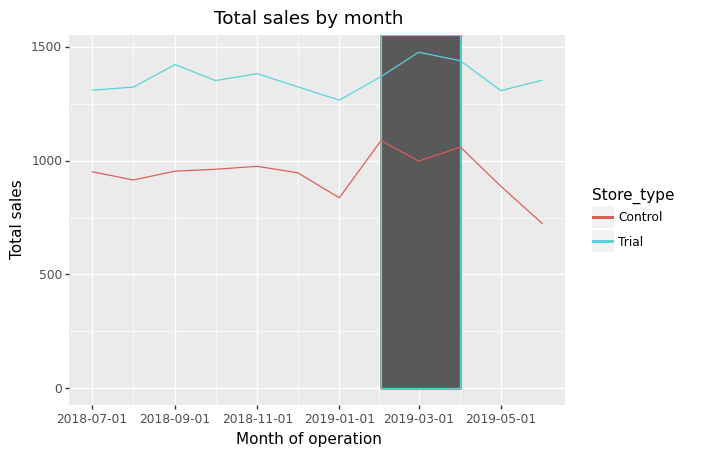

<ggplot: (8781246152364)>

In [310]:
### creating visualisation for stores 88,178 sales ###
trial_dataframe88_178=sales_for_visualisation(88,178)


rect_data = trial_dataframe88_178[(trial_dataframe88_178['yyyymm'].astype(int) < 201905) &
                            (trial_dataframe88_178['yyyymm'].astype(int) > 201901)]

transaction_month = pd.to_datetime(rect_data['TransactionMonth'])
xmin = transaction_month.min()
xmax = transaction_month.max()
ymin=0
ymax=float('inf')


ggplot(trial_dataframe88_178, aes('TransactionMonth', 'totSales', color='Store_type')) \
    + geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin,
                  ymax=ymax,alpha=0.2 ), show_legend=False)\
    + geom_line() + labs(x="Month of operation", y="Total sales", title="Total sales by month")


### Assessing number of customers ###


### Finding the scaling factor ###

In [202]:
scaling_88_178_customer=pretrial_customer_88.sum()/pretrial_customer_178.sum()

### Scaling up the control stores & finding the percentage difference. ###

In [203]:
custtable88 = pd.concat([pretrial_customer_88, trial_monthly_customer_88])
scaledcusttable178 = pd.concat([pretrial_customer_178, trial_monthly_customer_178])*scaling_88_178_customer
mergedcust88_178 = pd.merge(custtable88, scaledcusttable178, left_index=True, right_index=True)
mergedcust88_178.rename(columns={'LYLTY_CARD_NBR_x': 'customerTable88', 'LYLTY_CARD_NBR_y': 'scaledCustomerTable178'}, inplace=True)
mergedcust88_178['percentagediff']=(abs(mergedcust88_178['scaledCustomerTable178']-mergedcust88_178['customerTable88']))/mergedcust88_178['scaledCustomerTable178']

## Finding the stdev and the t_value ###


In [204]:
#finding the standard deviation
mergedcust88_178['YEARMONTH']=mergedcust88_178.index
mergedcust88_178['YEARMONTH']=mergedcust88_178['YEARMONTH'].astype(int)
stdDev = np.std(mergedcust88_178[mergedcust88_178['YEARMONTH'] < 201902]['percentagediff'].values)
degreesOfFreedom = 7

In [177]:
#finding the t_value
mergedcust88_178['tValue'] = (mergedcust88_178['percentagediff'] - 0) / stdDev
mergedcust88_178['TransactionMonth'] = pd.to_datetime(mergedcust88_178['YEARMONTH'].astype(str), format='%Y%m')
#finding the t_value of 2019-02, 2019-03, 2019-04
resultcust88_178 = mergedcust88_178[(mergedcust88_178['YEARMONTH'] < 201905) & (mergedcust88_178['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
#the t value of the 95th percentile
t_value = t.ppf(0.95, df=degreesOfFreedom)

print(resultcust88_178)
print('the t value of the 95th percentile:', t_value)

       TransactionMonth    tValue
yyyymm                           
201902       2019-02-01  3.166641
201903       2019-03-01  2.070771
201904       2019-04-01  7.458868
the t value of the 95th percentile: 1.894578605061305


### Let's create a nice plot to show our results ###


In [179]:
#Let's use the function we've created for sales
customer88_178_dataframe=sales_for_visualisation(88,178)
#customer88_178_dataframe

In [180]:
rect_data = customer88_178_dataframe[(customer88_178_dataframe['yyyymm'].astype(int) < 201905) &
                            (customer88_178_dataframe['yyyymm'].astype(int) > 201901)]

In [181]:
transaction_month = pd.to_datetime(rect_data['TransactionMonth'])
xmin = transaction_month.min()
xmax = transaction_month.max()
ymin=0
ymax=float('inf')

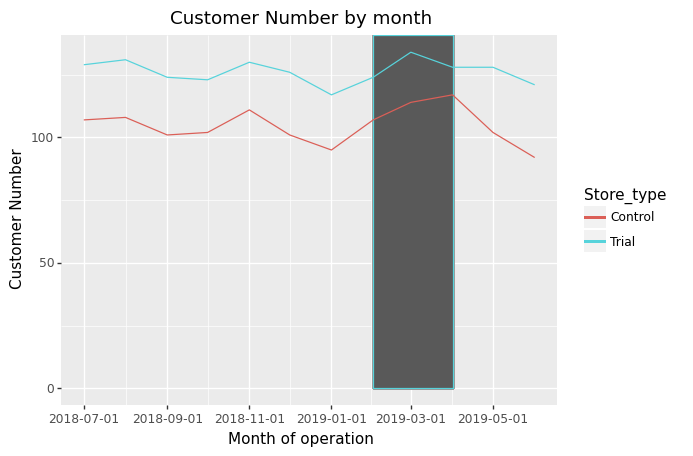

<ggplot: (8781246169254)>

In [182]:
ggplot(customer88_178_dataframe, aes('TransactionMonth', 'nCustomers', color='Store_type')) \
    + geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin,
                  ymax=ymax,alpha=0.2 ), show_legend=False)\
    + geom_line() + labs(x="Month of operation", y="Customer Number", title="Customer Number by month")
